## Section 7: **Fulfilling Requirements 6, 7**

In [ ]:
# !pip install --upgrade --force-reinstall torch torchvision torchaudio

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# all modules/libraries needed to run this notebook
import os
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import ConcatDataset
import random
import pandas as pd
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from PIL import Image

# **Requirement 6**: Implement the modifications you proposed in 5) and repeat the training, validation, and testing process according to the protocol in 1) for the modified methods. [10%]

#### To fulfill this requirement, we trained \the chosen GoogLeNet model's feature extractor and classifier on the offline augmented dataset `augmented_seed_segment_train_googlenet` that we generated from `seedsegment/train`. We then used the `seedsegment/test` as the validation set and, the `Test_LightBox_Seeds` and `Test_NormalRoomLight_Seeds` served as the testing sets.

The following cell processes the train and validation datasets.

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import random
import os
from PIL import Image

# set seed for reproducibility
SEED = 1000

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# our offline augmented dataset + train original dataset
train_dir = "/content/drive/MyDrive/Computer Vision Coursework/augmented_seed_segment_train_googlenet"
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# calculated from the AAR dataset (see FinalNotebook1.ipynb)
mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

original_dataset = ImageFolder(root=train_dir, transform=transform)
original_dataset.samples.sort()

train_dataset = original_dataset

val_dataset = ImageFolder(root=val_dir, transform=transform)
val_dataset.samples.sort()

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Class to index Mapping (train):", train_dataset.class_to_idx)
print("Class to index Mapping (val):", val_dataset.class_to_idx)


Train dataset size: 3504
Validation dataset size: 401
Class to index Mapping (train): {'BadSeed': 0, 'GoodSeed': 1}
Class to index Mapping (val): {'BadSeed': 0, 'GoodSeed': 1}


In [ ]:
# model training function for GoogLeNet
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_acc = 0.0
    best_model_wts = None
    epochs_not_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.3f} - Train Accuracy: {epoch_acc:.3f}")

        # validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_acc:.3f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            epochs_not_improve = 0
        else:
            epochs_not_improve += 1
            if epochs_not_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # load best weights before returning
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

In [ ]:
# function to evaluate the model on the test set (batch 2 and 3)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader, test_dataset):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # auc

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if isinstance(outputs, tuple):  # googlenet might return aux output
                outputs = outputs[0]

            # predicted class labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # get predicted probabilities for AUC (softmax output)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # get probabilities
            all_probs.extend(probs.cpu().numpy()[:, 1])  # for binary classification, class 1 probabilities

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='binary')
    rec = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)  # AUC score

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1, auc

Here, the pre-trained GoogLeNet model is initialised and the final connected layer is adapted to classify to 2 classes (BadSeed and GoodSeed)

In [ ]:
# get model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.googlenet(pretrained=True)

# modify final fully connected layer for 2 classes (good/bad seeds) and aux logit set to False by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 166MB/s]


Training the model using `train_model` function which has a maximum number of 25 epochs and involves early stopping when it converges.

In [ ]:
# default loss and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training the model on the vanilla batch 1 train set
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5)
# save model
torch.save(model.state_dict(), "/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_trained_with_aug_modifications_batch1.pth")

Epoch 1/25 - Train Loss: 0.196 - Train Accuracy: 0.918
Validation Accuracy: 0.968

Epoch 2/25 - Train Loss: 0.110 - Train Accuracy: 0.963
Validation Accuracy: 0.973

Epoch 3/25 - Train Loss: 0.088 - Train Accuracy: 0.965
Validation Accuracy: 0.988

Epoch 4/25 - Train Loss: 0.066 - Train Accuracy: 0.974
Validation Accuracy: 0.975

Epoch 5/25 - Train Loss: 0.069 - Train Accuracy: 0.975
Validation Accuracy: 0.958

Epoch 6/25 - Train Loss: 0.048 - Train Accuracy: 0.983
Validation Accuracy: 0.930

Epoch 7/25 - Train Loss: 0.048 - Train Accuracy: 0.984
Validation Accuracy: 0.908

Epoch 8/25 - Train Loss: 0.031 - Train Accuracy: 0.988
Validation Accuracy: 0.945

Early stopping at epoch 8


This cell involves the evaluation of the fine-tuned GoogLeNet model on Batch 1, `seedsegment/test`.

Accuracy: 0.945
Precision: 1.000
Recall: 0.891
F1 Score: 0.942
AUC Score: 0.992


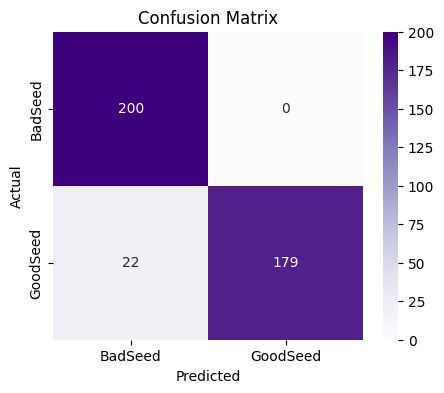

(0.9451371571072319,
 1.0,
 0.8905472636815921,
 0.9421052631578948,
 np.float64(0.992363184079602))

In [ ]:
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"
evaluate_model(model, val_loader, val_dataset)

The following two cells involved evaluating the model on Batch 2 and Batch 3: `Test_NormalRoomLight_Seeds` and `Test_LightBox_Seeds`

In [ ]:
# testing the trained model on batch 2 and 3
test_dir1 = "/content/drive/MyDrive/Computer Vision Coursework/Test_LightBox_Seeds"
test_dir2 = "/content/drive/MyDrive/Computer Vision Coursework/Test_NormalRoomLight_Seeds"

test_dataset1 = ImageFolder(root=test_dir1, transform=transform)
test_dataset2 = ImageFolder(root=test_dir2, transform=transform)

print("class to index Mapping (test batch 1):", test_dataset1.class_to_idx)
print("class to index Mapping (test batch 2):", test_dataset2.class_to_idx)

test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False, num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False, num_workers=2)

class to index Mapping (test batch 1): {'BadSeed': 0, 'GoodSeed': 1}
class to index Mapping (test batch 2): {'BadSeed': 0, 'GoodSeed': 1}


Evaluating on Test Set 1 (LightBox):
Accuracy: 0.851
Precision: 0.813
Recall: 0.917
F1 Score: 0.862
AUC Score: 0.916


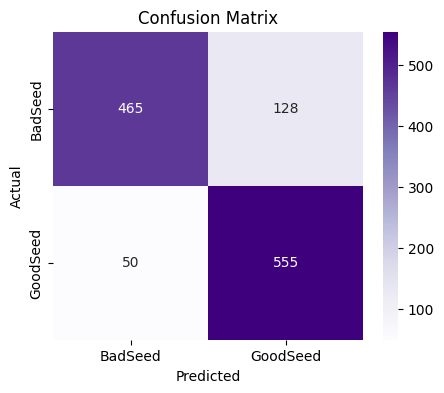

Evaluating on Test Set 2 (Normal Room Light):
Accuracy: 0.871
Precision: 0.917
Recall: 0.816
F1 Score: 0.864
AUC Score: 0.942


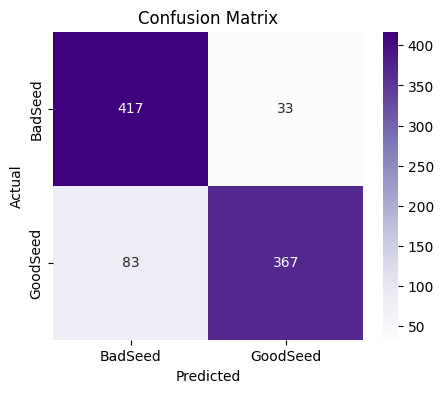

(0.8711111111111111,
 0.9175,
 0.8155555555555556,
 0.8635294117647059,
 np.float64(0.9418814814814815))

In [ ]:
# test on both datasets 299X299
print("Evaluating on Test Set 1 (LightBox):")
evaluate_model(model, test_loader1, test_dataset1)

print("Evaluating on Test Set 2 (Normal Room Light):")
evaluate_model(model, test_loader2, test_dataset2)

# **Requirement 7**: For the modified method(s), repeat the analysis in 4) but only pertaining to the items you choose to improve on as justified in 6). [10%]

Repeating feature and classifier analysis on the proposed modifications model

## Feature Analysis
### **Experimental Setup**
The analysis will focus on **validation dataset in Batch-1 (seedsegment/test)**, and uses **Cosine Similarity**, **Pearson Coefficient** and **Euclidean Distance** (L2 norm) to assess how consistent the proposed modification model's internal representations (feature maps) are before and after applying each transformation.
- **Transformations Applied:**
  1. *Translation*: Shift image by ±10%, ±20%, ±30%
  2. *Rotation*: Rotate by ±15°, ±30°, ±45°, ±90°, ±180°, ±360°
  3. *Scaling*: Resize image by 0.8×, 1.2×, 1.5×
  4. *Noise*: σ = 0.01, 0.05, 0.1
  5. *Illumination*: brightness change to 0.5 (dimmer than normal), 1.5 (brighter than normal)

  Each transformation is applied individually to measure its isolated effect. GoogleNet retrained on the `augmented_seed_segment_train_googlenet` dataset (from Requirment 6) will be used to compare the **original data's vs. transformed data's feature vectors**.

**Outcome**
This analysis will provide empirical insight into the **transformation invariance** of proposed modification GoogLeNet's 1024-dimensional feature vectors.

The following cells loads the validation dataset, feeds it into the proposed modified fine-tuned GoogLeNet feature extractor. The feature maps of the original images vs the augmented images (one transform at a time) are then compared.

In [ ]:
# remove classifier by replacing with identity (feature extractor only)
model.fc = nn.Identity()
model.to(device)

def extract_features(dataloader, model):
    features = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features)

In [ ]:
def add_gaussian_noise(img, mean, std):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)  # pixel values remain valid

def add_random_translation(img, max_shift):
    translation = transforms.RandomAffine(degrees=0, translate=(max_shift, max_shift))
    return translation(img)

def add_random_rotation(img, max_angle):
    rotation = transforms.RandomRotation(degrees=max_angle)
    return rotation(img)

def add_random_scaling(img, scale_val):
    scaling = transforms.RandomAffine(degrees=0, scale=(scale_val, scale_val))
    return scaling(img)

def add_random_illumination(img, brightness):
    illumination = transforms.ColorJitter(brightness=brightness)
    return illumination(img)

# creating the different transforms to apply to the train set before training the feature extractor for googlenet
resize_shape = (299, 299)
#  this mean and std are extracted from FinalNotebook1.ipynb
mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

def create_transform(augmentation_func=None, **kwargs):
    aug = transforms.Lambda(lambda x: augmentation_func(x, **kwargs)) if augmentation_func else lambda x: x
    return transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.ToTensor(),
        aug,
        transforms.Normalize(mean=mean, std=std)
    ])

original_transform = create_transform(None)

# brightness 0.5 & 1.5
transform_brightness0_5 = create_transform(add_random_illumination, brightness=0.5)
transform_brightness1_5 = create_transform(add_random_illumination, brightness=1.5)

# noise 0.01, 0.05, 0.1
transform_noise0_01 = create_transform(add_gaussian_noise, mean=0.0, std=0.01)
transform_noise0_05 = create_transform(add_gaussian_noise, mean=0.0, std=0.05)
transform_noise0_1  = create_transform(add_gaussian_noise, mean=0.0, std=0.1)

# scale 0.8, 1.2, 1.5
transform_scale0_8 = create_transform(add_random_scaling, scale_val=0.8)
transform_scale1_2 = create_transform(add_random_scaling, scale_val=1.2)
transform_scale1_5 = create_transform(add_random_scaling, scale_val=1.5)

# rotate 15,30,45,90,180,360
transform_rotate15   = create_transform(add_random_rotation, max_angle=15)
transform_rotate30   = create_transform(add_random_rotation, max_angle=30)
transform_rotate45   = create_transform(add_random_rotation, max_angle=45)
transform_rotate90   = create_transform(add_random_rotation, max_angle=90)
transform_rotate180  = create_transform(add_random_rotation, max_angle=180)
transform_rotate360  = create_transform(add_random_rotation, max_angle=360)

# translate 0.1, 0.2, 0.3
transform_translate0_1 = create_transform(add_random_translation, max_shift=0.1)
transform_translate0_2 = create_transform(add_random_translation, max_shift=0.2)
transform_translate0_3 = create_transform(add_random_translation, max_shift=0.3)


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import numpy as np

def compare_features_all(features1, features2):
    assert features1.shape == features2.shape, "Feature arrays must be the same shape"
    cosine_sims = []
    euclidean_dists = []
    pearson_coeffs = []

    for f1, f2 in zip(features1, features2):
        cos_sim = cosine_similarity([f1], [f2])[0][0]
        cosine_sims.append(cos_sim)
        dist = euclidean(f1, f2)
        euclidean_dists.append(dist)
        r, _ = pearsonr(f1, f2)
        pearson_coeffs.append(r)

    return {
        "cosine": {
            "mean": np.mean(cosine_sims),
            "std": np.std(cosine_sims)
        },
        "euclidean": {
            "mean": np.mean(euclidean_dists),
            "std": np.std(euclidean_dists)
        },
        "pearson": {
            "mean": np.mean(pearson_coeffs),
            "std": np.std(pearson_coeffs)
        }
    }
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# load the dataset and apply the transforms
val_dataset = ImageFolder(root=val_dir, transform=original_transform) # applies default resize, totensor and normalisation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

val_dataset0 = ImageFolder(root=val_dir, transform=transform_brightness0_5)
val_loader0 = DataLoader(val_dataset0, batch_size=32, shuffle=False, num_workers=2)

val_dataset1 = ImageFolder(root=val_dir, transform=transform_brightness1_5)
val_loader1 = DataLoader(val_dataset1, batch_size=32, shuffle=False, num_workers=2)

val_dataset2 = ImageFolder(root=val_dir, transform=transform_noise0_01)
val_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False, num_workers=2)

val_dataset3 = ImageFolder(root=val_dir, transform=transform_noise0_05)
val_loader3 = DataLoader(val_dataset3, batch_size=32, shuffle=False, num_workers=2)

val_dataset4 = ImageFolder(root=val_dir, transform=transform_noise0_1)
val_loader4 = DataLoader(val_dataset4, batch_size=32, shuffle=False, num_workers=2)

val_dataset5 = ImageFolder(root=val_dir, transform=transform_scale0_8)
val_loader5 = DataLoader(val_dataset5, batch_size=32, shuffle=False, num_workers=2)

val_dataset6 = ImageFolder(root=val_dir, transform=transform_scale1_2)
val_loader6 = DataLoader(val_dataset6, batch_size=32, shuffle=False, num_workers=2)

val_dataset7 = ImageFolder(root=val_dir, transform=transform_scale1_5)
val_loader7 = DataLoader(val_dataset7, batch_size=32, shuffle=False, num_workers=2)

val_dataset8 = ImageFolder(root=val_dir, transform=transform_rotate15)
val_loader8 = DataLoader(val_dataset8, batch_size=32, shuffle=False, num_workers=2)

val_dataset9 = ImageFolder(root=val_dir, transform=transform_rotate30)
val_loader9 = DataLoader(val_dataset9, batch_size=32, shuffle=False, num_workers=2)

val_dataset10 = ImageFolder(root=val_dir, transform=transform_rotate45)
val_loader10 = DataLoader(val_dataset10, batch_size=32, shuffle=False, num_workers=2)

val_dataset11 = ImageFolder(root=val_dir, transform=transform_rotate90)
val_loader11 = DataLoader(val_dataset11, batch_size=32, shuffle=False, num_workers=2)

val_dataset12 = ImageFolder(root=val_dir, transform=transform_rotate180)
val_loader12 = DataLoader(val_dataset12, batch_size=32, shuffle=False, num_workers=2)

val_dataset13 = ImageFolder(root=val_dir, transform=transform_rotate360)
val_loader13 = DataLoader(val_dataset13, batch_size=32, shuffle=False, num_workers=2)

val_dataset14 = ImageFolder(root=val_dir, transform=transform_translate0_1)
val_loader14 = DataLoader(val_dataset14, batch_size=32, shuffle=False, num_workers=2)

val_dataset15 = ImageFolder(root=val_dir, transform=transform_translate0_2)
val_loader15 = DataLoader(val_dataset15, batch_size=32, shuffle=False, num_workers=2)

val_dataset16 = ImageFolder(root=val_dir, transform=transform_translate0_3)
val_loader16 = DataLoader(val_dataset16, batch_size=32, shuffle=False, num_workers=2)

# extract the features from trained GoogleNet model on the transformed data
features = extract_features(val_loader, model)
features0 = extract_features(val_loader0, model)
features1 = extract_features(val_loader1, model)
features2 = extract_features(val_loader2, model)
features3 = extract_features(val_loader3, model)
features4 = extract_features(val_loader4, model)
features5 = extract_features(val_loader5, model)
features6 = extract_features(val_loader6, model)
features7 = extract_features(val_loader7, model)
features8 = extract_features(val_loader8, model)
features9 = extract_features(val_loader9, model)
features10 = extract_features(val_loader10, model)
features11 = extract_features(val_loader11, model)
features12 = extract_features(val_loader12, model)
features13 = extract_features(val_loader13, model)
features14 = extract_features(val_loader14, model)
features15 = extract_features(val_loader15, model)
features16 = extract_features(val_loader16, model)

print(features.shape)

metrics = compare_features_all(features, features) # cross checking ->
metrics0 = compare_features_all(features, features0)
metrics1 = compare_features_all(features, features1)
metrics2 = compare_features_all(features, features2)
metrics3 = compare_features_all(features, features3)
metrics4 = compare_features_all(features, features4)
metrics5 = compare_features_all(features, features5)
metrics6 = compare_features_all(features, features6)
metrics7 = compare_features_all(features, features7)
metrics8 = compare_features_all(features, features8)
metrics9 = compare_features_all(features, features9)
metrics10 = compare_features_all(features, features10)
metrics11 = compare_features_all(features, features11)
metrics12 = compare_features_all(features, features12)
metrics13 = compare_features_all(features, features13)
metrics14 = compare_features_all(features, features14)
metrics15 = compare_features_all(features, features15)
metrics16 = compare_features_all(features, features16)


results_dict = {
    "Comparison": [
        "Original vs. Original", "Original vs. Brightness 0.5x", "Original vs. Brightness 1.5x",
        "Original vs. Gaussian Noise σ = 0.01", "Original vs. Gaussian Noise σ = 0.05", "Original vs. Gaussian Noise σ = 0.1",
        "Original vs. Scale 0.8x", "Original vs. Scale 1.2x", "Original vs. Scale 1.5x", "Original vs. Rotation 15°",
        "Original vs. Rotation 30°", "Original vs. Rotation 45°", "Original vs. Rotation 90°", "Original vs. Rotation 180°",
        "Original vs. Rotation 360°", "Original vs. Translation 10%", "Original vs. Translation 20%", "Original vs. Translation 30%"
    ],
    "Cosine Similarity (mean)": [
        round(metrics['cosine']['mean'], 2), round(metrics0['cosine']['mean'], 2), round(metrics1['cosine']['mean'], 2),
        round(metrics2['cosine']['mean'], 2), round(metrics3['cosine']['mean'], 2), round(metrics4['cosine']['mean'], 2),
        round(metrics5['cosine']['mean'], 2), round(metrics6['cosine']['mean'], 2), round(metrics7['cosine']['mean'], 2),
        round(metrics8['cosine']['mean'], 2), round(metrics9['cosine']['mean'], 2), round(metrics10['cosine']['mean'], 2),
        round(metrics11['cosine']['mean'], 2), round(metrics12['cosine']['mean'], 2), round(metrics13['cosine']['mean'], 2),
        round(metrics14['cosine']['mean'], 2), round(metrics15['cosine']['mean'], 2), round(metrics16['cosine']['mean'], 2)
    ],
    "Cosine Similarity (std)": [
        round(metrics['cosine']['std'], 2), round(metrics0['cosine']['std'], 2), round(metrics1['cosine']['std'], 2),
        round(metrics2['cosine']['std'], 2), round(metrics3['cosine']['std'], 2), round(metrics4['cosine']['std'], 2),
        round(metrics5['cosine']['std'], 2), round(metrics6['cosine']['std'], 2), round(metrics7['cosine']['std'], 2),
        round(metrics8['cosine']['std'], 2), round(metrics9['cosine']['std'], 2), round(metrics10['cosine']['std'], 2),
        round(metrics11['cosine']['std'], 2), round(metrics12['cosine']['std'], 2), round(metrics13['cosine']['std'], 2),
        round(metrics14['cosine']['std'], 2), round(metrics15['cosine']['std'], 2), round(metrics16['cosine']['std'], 2)
    ],
    "Euclidean Distance (mean)": [
        round(metrics['euclidean']['mean'], 2), round(metrics0['euclidean']['mean'], 2), round(metrics1['euclidean']['mean'], 2),
        round(metrics2['euclidean']['mean'], 2), round(metrics3['euclidean']['mean'], 2), round(metrics4['euclidean']['mean'], 2),
        round(metrics5['euclidean']['mean'], 2), round(metrics6['euclidean']['mean'], 2), round(metrics7['euclidean']['mean'], 2),
        round(metrics8['euclidean']['mean'], 2), round(metrics9['euclidean']['mean'], 2), round(metrics10['euclidean']['mean'], 2),
        round(metrics11['euclidean']['mean'], 2), round(metrics12['euclidean']['mean'], 2), round(metrics13['euclidean']['mean'], 2),
        round(metrics14['euclidean']['mean'], 2), round(metrics15['euclidean']['mean'], 2), round(metrics16['euclidean']['mean'], 2)
    ],
    "Euclidean Distance (std)": [
        round(metrics['euclidean']['std'], 2), round(metrics0['euclidean']['std'], 2), round(metrics1['euclidean']['std'], 2),
        round(metrics2['euclidean']['std'], 2), round(metrics3['euclidean']['std'], 2), round(metrics4['euclidean']['std'], 2),
        round(metrics5['euclidean']['std'], 2), round(metrics6['euclidean']['std'], 2), round(metrics7['euclidean']['std'], 2),
        round(metrics8['euclidean']['std'], 2), round(metrics9['euclidean']['std'], 2), round(metrics10['euclidean']['std'], 2),
        round(metrics11['euclidean']['std'], 2), round(metrics12['euclidean']['std'], 2), round(metrics13['euclidean']['std'], 2),
        round(metrics14['euclidean']['std'], 2), round(metrics15['euclidean']['std'], 2), round(metrics16['euclidean']['std'], 2)
    ],
    "Pearson Correlation (mean)": [
        round(metrics['pearson']['mean'], 2), round(metrics0['pearson']['mean'], 2), round(metrics1['pearson']['mean'], 2),
        round(metrics2['pearson']['mean'], 2), round(metrics3['pearson']['mean'], 2), round(metrics4['pearson']['mean'], 2),
        round(metrics5['pearson']['mean'], 2), round(metrics6['pearson']['mean'], 2), round(metrics7['pearson']['mean'], 2),
        round(metrics8['pearson']['mean'], 2), round(metrics9['pearson']['mean'], 2), round(metrics10['pearson']['mean'], 2),
        round(metrics11['pearson']['mean'], 2), round(metrics12['pearson']['mean'], 2), round(metrics13['pearson']['mean'], 2),
        round(metrics14['pearson']['mean'], 2), round(metrics15['pearson']['mean'], 2), round(metrics16['pearson']['mean'], 2)
    ],
    "Pearson Correlation (std)": [
        round(metrics['pearson']['std'], 2), round(metrics0['pearson']['std'], 2), round(metrics1['pearson']['std'], 2),
        round(metrics2['pearson']['std'], 2), round(metrics3['pearson']['std'], 2), round(metrics4['pearson']['std'], 2),
        round(metrics5['pearson']['std'], 2), round(metrics6['pearson']['std'], 2), round(metrics7['pearson']['std'], 2),
        round(metrics8['pearson']['std'], 2), round(metrics9['pearson']['std'], 2), round(metrics10['pearson']['std'], 2),
        round(metrics11['pearson']['std'], 2), round(metrics12['pearson']['std'], 2), round(metrics13['pearson']['std'], 2),
        round(metrics14['pearson']['std'], 2), round(metrics15['pearson']['std'], 2), round(metrics16['pearson']['std'], 2)
    ]
}


(401, 1024)


In [ ]:
df = pd.DataFrame(results_dict)

df.to_csv("/content/drive/MyDrive/Computer Vision Coursework/results/feature_comparison_results_modified_model.csv", index=False)

print("Results have been exported to 'feature_comparison_results_modified_model.csv'")
df = pd.read_csv("/content/drive/MyDrive/Computer Vision Coursework/results/feature_comparison_results_modified_model.csv")
df

Results have been exported to 'feature_comparison_results_modified_model.csv'


,Comparison,Cosine Similarity (mean),Cosine Similarity (std),Euclidean Distance (mean),Euclidean Distance (std),Pearson Correlation (mean),Pearson Correlation (std)
0,Original vs. Original,1.00,0.00,0.00,0.00,1.00,0.00
1,Original vs. Brightness 0.5x,0.97,0.09,3.08,3.30,0.95,0.14
2,Original vs. Brightness 1.5x,0.81,0.28,6.20,5.36,0.71,0.41
3,Original vs. Gaussian Noise σ = 0.01,1.00,0.01,0.58,0.27,1.00,0.01
4,Original vs. Gaussian Noise σ = 0.05,0.86,0.20,4.60,2.50,0.74,0.38
5,Original vs. Gaussian Noise σ = 0.1,0.63,0.35,8.23,3.78,0.43,0.54
6,Original vs. Scale 0.8x,0.97,0.08,2.94,1.58,0.93,0.18
7,Original vs. Scale 1.2x,0.98,0.04,2.13,1.22,0.97,0.10
8,Original vs. Scale 1.5x,0.95,0.10,4.06,2.24,0.90,0.22
9,Original vs. Rotation 15°,0.99,0.02,1.22,0.79,0.99,0.04


In [ ]:
# del model
# torch.cuda.empty_cache()

## Visualisation of class activation maps

In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 973.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import googlenet
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = googlenet(weights=None, aux_logits=False, init_weights=True)
model.fc = nn.Linear(1024, 2)
state_dict = torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_trained_with_aug_modifications_batch1.pth")
model.load_state_dict(state_dict)
model.to(device).eval()

original_transform = create_transform()

def generate_cam(image_path, target_layer):
    img = Image.open(image_path).convert("RGB")
    input_tensor = original_transform(img).unsqueeze(0).to(device)
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
    out = model(input_tensor)
    class_idx = out.squeeze().argmax().item()
    predicted_label = "Bad Seed" if class_idx == 0 else "Good Seed"
    activation_map = cam_extractor(class_idx, out)[0].squeeze().cpu().numpy()
    heatmap_img = Image.fromarray(activation_map, mode='F')
    result = overlay_mask(img, heatmap_img, alpha=0.5)
    return result, predicted_label

image_info = [
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest9.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest177.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest18.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest195.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest74.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest19.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest13.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest139.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest119.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest102.png", "Bad Seed")
]

layers_to_check = [
    ("inception3a", model.inception3a),
    ("inception4a", model.inception4a),
    ("inception5b", model.inception5b)
]

fig, axes = plt.subplots(nrows=len(layers_to_check) + 1, ncols=len(image_info), figsize=(20, 10))


axes = axes.flatten()

for j, (path, actual) in enumerate(image_info):
    img = Image.open(path).convert("RGB")
    input_tensor = original_transform(img).unsqueeze(0).to(device)
    out = model(input_tensor)
    class_idx = out.squeeze().argmax().item()
    predicted_label = "Bad Seed" if class_idx == 0 else "Good Seed"

    ax = axes[j]
    ax.imshow(img)
    ax.set_title(f"\nActual: {actual}\nPred: {predicted_label}", fontsize=8)
    ax.axis('off')

    for i, (layer_name, target_layer) in enumerate(layers_to_check):
        result, _ = generate_cam(path, target_layer)
        ax = axes[(i + 1) * len(image_info) + j]
        ax.imshow(result)
        ax.set_title(f"{layer_name}", fontsize=8)
        ax.axis('off')


plt.tight_layout(h_pad = 0.1)
plt.subplots_adjust(hspace=0.01)
plt.show()

del model
torch.cuda.empty_cache()


Output hidden; open in https://colab.research.google.com to view.